> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

>Data columns (total 21 columns).

>id                      10866 non-null int64.

>imdb_id                 10856 non-null object.

>popularity              10866 non-null float64.

>budget                  10866 non-null int64.

>revenue                 10866 non-null int64.

>original_title          10866 non-null object.

>cast                    10790 non-null object.

>homepage                2936 non-null object.

>director                10822 non-null object.

>tagline                 8042 non-null object.

>keywords                9373 non-null object.

>overview                10862 non-null object.

>runtime                 10866 non-null int64.

>genres                  10843 non-null object.

>production_companies    9836 non-null object.

>release_date            10866 non-null object.

>vote_count              10866 non-null int64.

>vote_average            10866 non-null float64.

>release_year            10866 non-null int64.

>budget_adj              10866 non-null float64.

>revenue_adj             10866 non-null float64.



### Question(s) for Analysis
>Question1 Which year has the highest release of movies?.

>Question2  Profit Trends of movies over the years?.

>Question3 (Which Month Released Highest Number Of Movies In All Of The Years?.

>Question4 (Movie with highest And Lowest Earned Revenue?).

>Question5 (which movie spent high budget and another one spent low budget?).

>Question6 how does the Popularity of movie impact on Ratings?.

>Question7 what is the most Famous Actors by Popularity Score?.

>Question8 what is run time distribution  of all movies?.


In [3]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [4]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
# load dataset
df = pd.read_csv('Database_TMDb_movie_data/tmdb-movies.csv')
# print meta data about data
df.info()
# display the first 5 columns in dataset
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

(10866, 21)

In [5]:
# display discribtion of the data
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [6]:
df=df.fillna(0)


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [7]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df['release_date'] = pd.to_datetime(df['release_date'])

In [8]:
# drop duplicated rows
df.drop_duplicates(inplace=True)

In [9]:
# drop nonre values
df.dropna(subset=['genres'], inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10865 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10865 non-null object
homepage                10865 non-null object
director                10865 non-null object
tagline                 10865 non-null object
keywords                10865 non-null object
overview                10865 non-null object
runtime                 10865 non-null int64
genres                  10865 non-null object
production_companies    10865 non-null object
release_date            10865 non-null datetime64[ns]
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj   

In [10]:
df.drop(['budget_adj','revenue_adj','overview','imdb_id','homepage','tagline'],axis =1,inplace = True)

In [11]:
# make a new colunm called profit
df['Profit'] = df['revenue'] - df['budget']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 16 columns):
id                      10865 non-null int64
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10865 non-null object
director                10865 non-null object
keywords                10865 non-null object
runtime                 10865 non-null int64
genres                  10865 non-null object
production_companies    10865 non-null object
release_date            10865 non-null datetime64[ns]
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
Profit                  10865 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(6)
memory usage: 1.4+ MB



### Question 1 Which year has the highest release of movies?

Text(0.5,1,' highest release of movies over years')

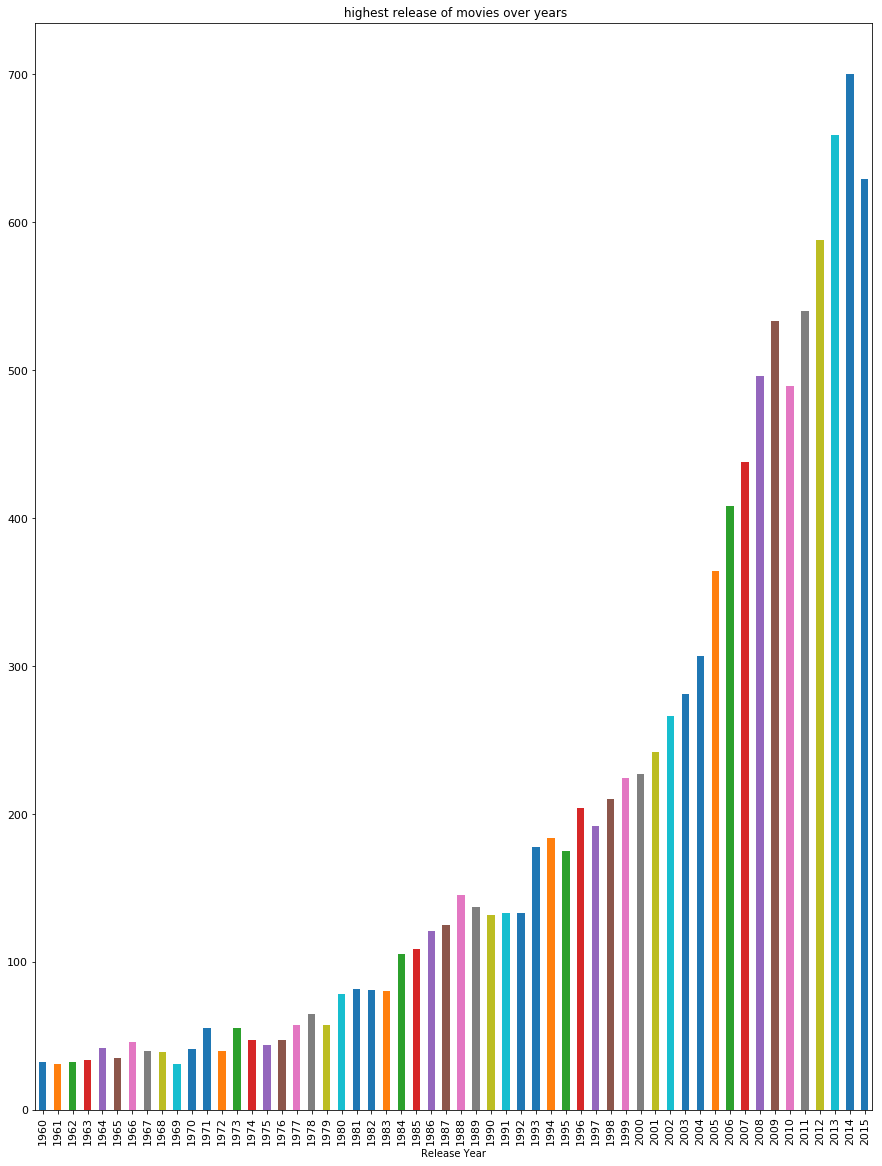

In [12]:
year_num= df.groupby('release_year').count()['id']
year_num.plot(kind='bar',fontsize = 11,figsize=(15,20))
plt.xlabel('Release Year', fontsize = 10)
plt.title(' highest release of movies over years')


### Question 2  Profit Trends of movies over the years?

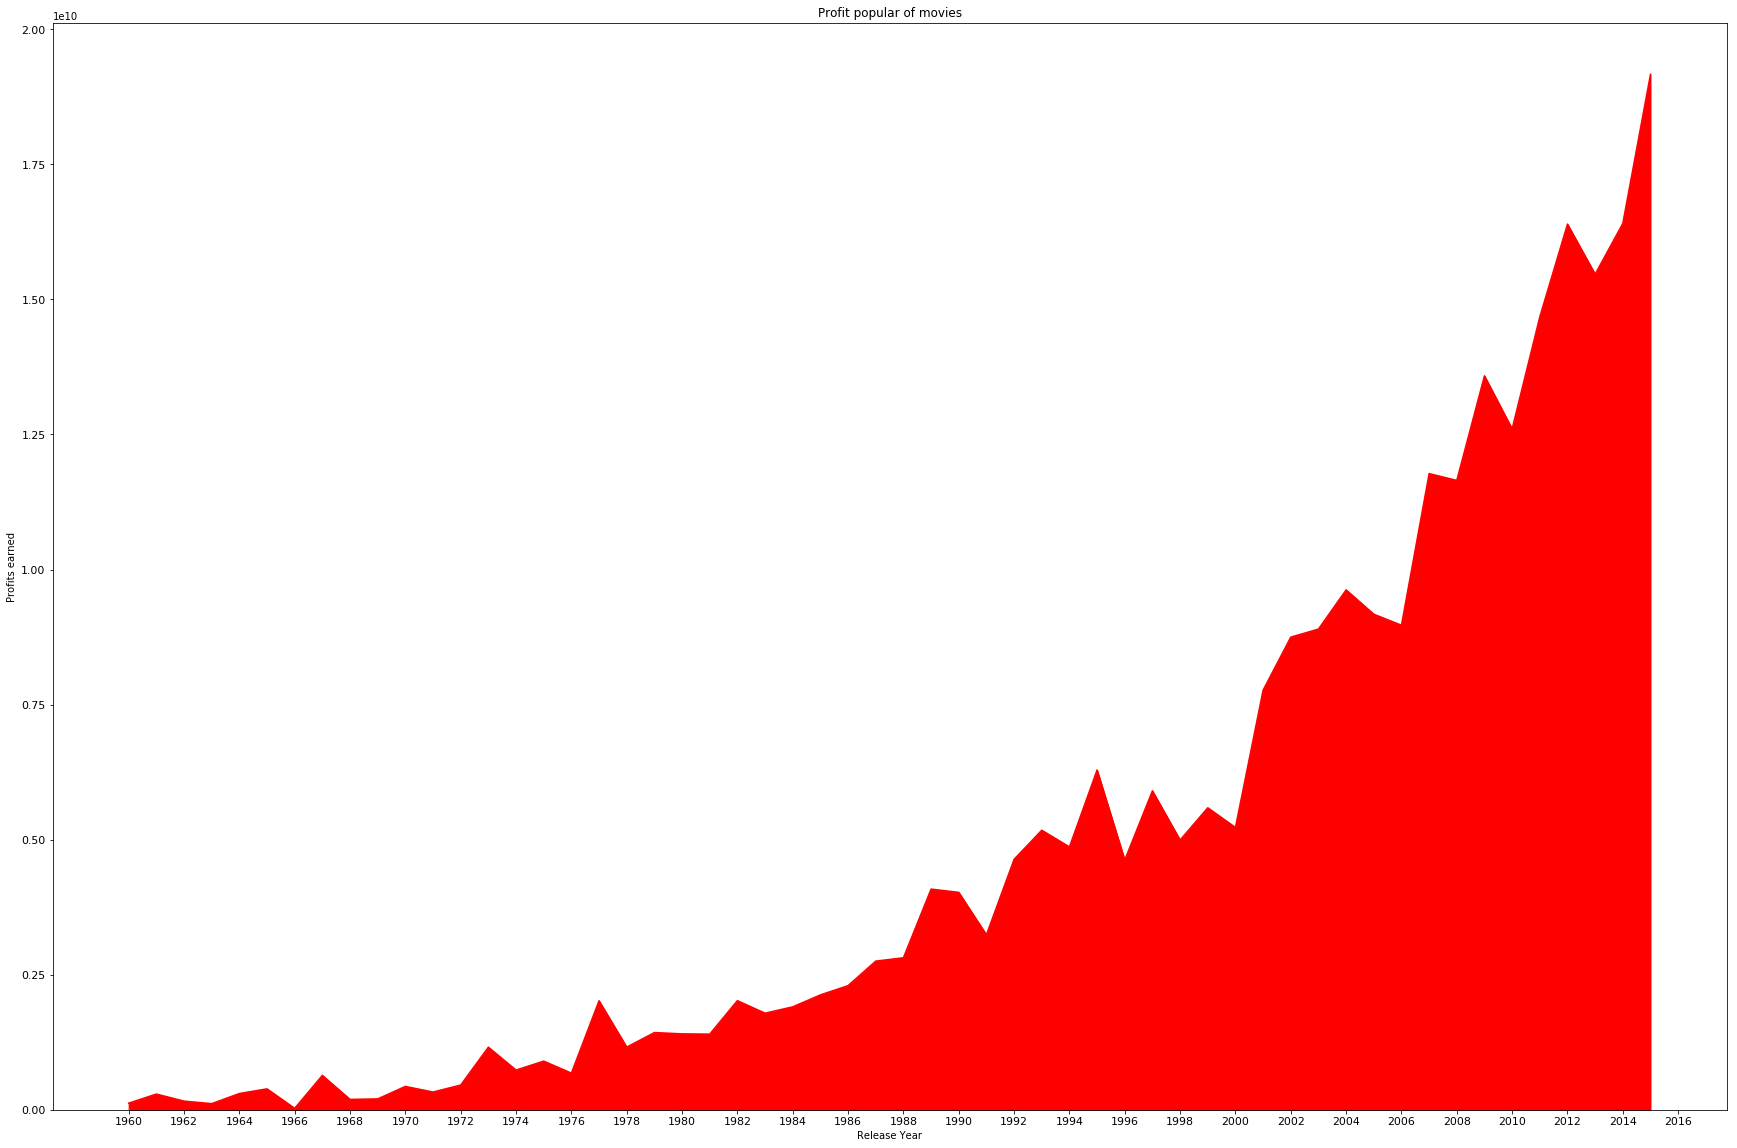

Maximum profited year 2015
Minimum profited year 1966


In [13]:
profit_year=df.groupby('release_year')['Profit'].sum()
profit_year.plot(kind='area',fontsize = 11,figsize=(30,20),color='r',xticks = np.arange(1960,2017,2))
MaximumValue = df.groupby('release_year')['Profit'].sum().idxmax()
MinumuValue = df.groupby('release_year')['Profit'].sum().idxmin()
plt.xlabel('Release Year', fontsize = 10)
plt.ylabel('Profits earned', fontsize = 10)
plt.title('Profit popular of movies')
plt.show()
print(f'Maximum profited year {MaximumValue}')
print(f'Minimum profited year {MinumuValue}')


# Question 3(Which Month Released Highest Number Of Movies In All Of The Years?

In [14]:
number_of_release=df['release_date'].dt.month.value_counts().sort_index()
number_of_release

1      919
2      691
3      822
4      797
5      809
6      827
7      799
8      918
9     1331
10    1153
11     814
12     985
Name: release_date, dtype: int64

mounth of max number of movies is sep


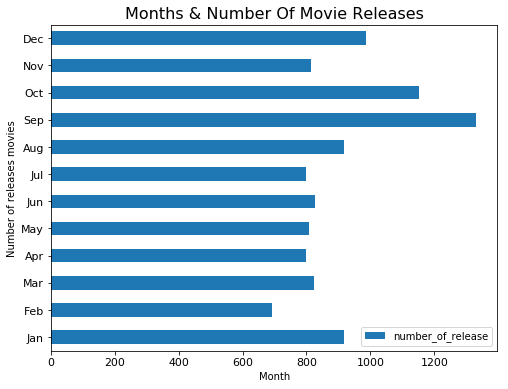

In [15]:
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
number_of_release = pd.DataFrame(number_of_release)
number_of_release['month'] = months
#change the column name of the new dataframe 'number_of_release'
number_of_release.rename(columns = {'release_date':'number_of_release'},inplace=True)

number_of_release.plot(x='month',kind='barh',fontsize = 11,figsize=(8,6))
#set the labels and titles of the plot.
plt.title('Months & Number Of Movie Releases',fontsize = 16)
plt.xlabel('Month',fontsize = 10)
plt.ylabel('Number of releases movies',fontsize = 10)
print('mounth of max number of movies is sep')

In [16]:
def maxmin(x):
    #use the function 'idmin' to find the index of lowest profit movie.
    minmumIndex = df[x].idxmin()
    #use the function 'idmax' to find the index of Highest profit movie.
    highestIndex = df[x].idxmax()
    high = pd.DataFrame(df.loc[highestIndex,:])
    low = pd.DataFrame(df.loc[minmumIndex,:])
    #print the movie with high and low profit
    print(f"Movie with Highest {x}  : {df['original_title'][minmumIndex]}")
    print(f"Movie With Lowest {x}  : {df['original_title' ][highestIndex]}")
    return pd.concat([high,low],axis = 1)

# Question 4 (Movie with highest And Lowest Earned Revenue?)

In [17]:
maxmin('revenue')

Movie with Highest revenue  : Wild Card
Movie With Lowest revenue  : Avatar


,1386,48
id,19995,265208
popularity,9.43277,2.93234
budget,237000000,30000000
revenue,2781505847,0
original_title,Avatar,Wild Card
cast,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,Jason Statham|Michael Angarano|Milo Ventimigli...
director,James Cameron,Simon West
keywords,culture clash|future|space war|space colony|so...,gambling|bodyguard|remake
runtime,162,92
genres,Action|Adventure|Fantasy|Science Fiction,Thriller|Crime|Drama


<function matplotlib.pyplot.show(*args, **kw)>

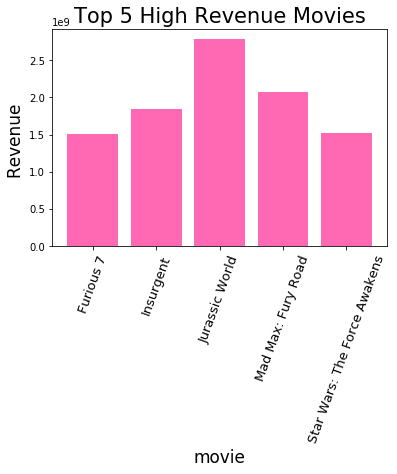

In [18]:
data = list(map(str,(df['original_title'])))
titel = list(data[:5])
revenue = list(df['revenue'].sort_values(ascending = False)[:5])
plt.bar(titel, revenue,color = "hotpink")
plt.title("Top 5 High Revenue Movies",fontsize = 21)
plt.ylabel('Revenue ', fontsize = 17)
plt.xlabel('movie', fontsize = 17)
plt.xticks(rotation = 70, fontsize = 13)
plt.show


# Question5 (which movie spent high budget and another one spent low budget?)

In [19]:
maxmin('budget')

Movie with Highest budget  : Mr. Holmes
Movie With Lowest budget  : The Warrior's Way


,2244,30
id,46528,280996
popularity,0.25054,3.92733
budget,425000000,0
revenue,11087569,29355203
original_title,The Warrior's Way,Mr. Holmes
cast,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...,Ian McKellen|Milo Parker|Laura Linney|Hattie M...
director,Sngmoo Lee,Bill Condon
keywords,assassin|small town|revenge|deception|super speed,london|detective|sherlock holmes
runtime,100,103
genres,Adventure|Fantasy|Action|Western|Thriller,Mystery|Drama


<function matplotlib.pyplot.show(*args, **kw)>

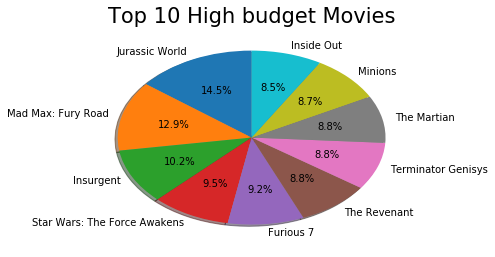

In [20]:
data = list(map(str,(df['original_title'])))
titel = list(data[:10])
revenue = list(df['budget'].sort_values(ascending = False)[:10])
plt.pie(revenue, labels=titel,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Top 10 High budget Movies",fontsize = 21)
plt.xticks(rotation = 70, fontsize = 13)
plt.show

# Question 6how does the Popularity of movie impact on Ratings

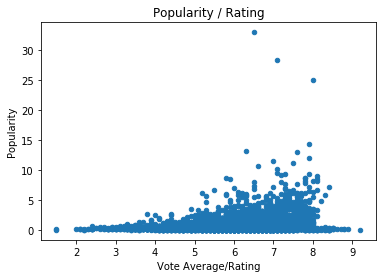

In [21]:
df.plot(x='vote_average',y='popularity',kind='scatter')
plt.title('Popularity / Rating')
plt.xlabel('Vote Average/Rating')
plt.ylabel('Popularity');

# Question7  what is the most Famous Actors by Popularity Score?

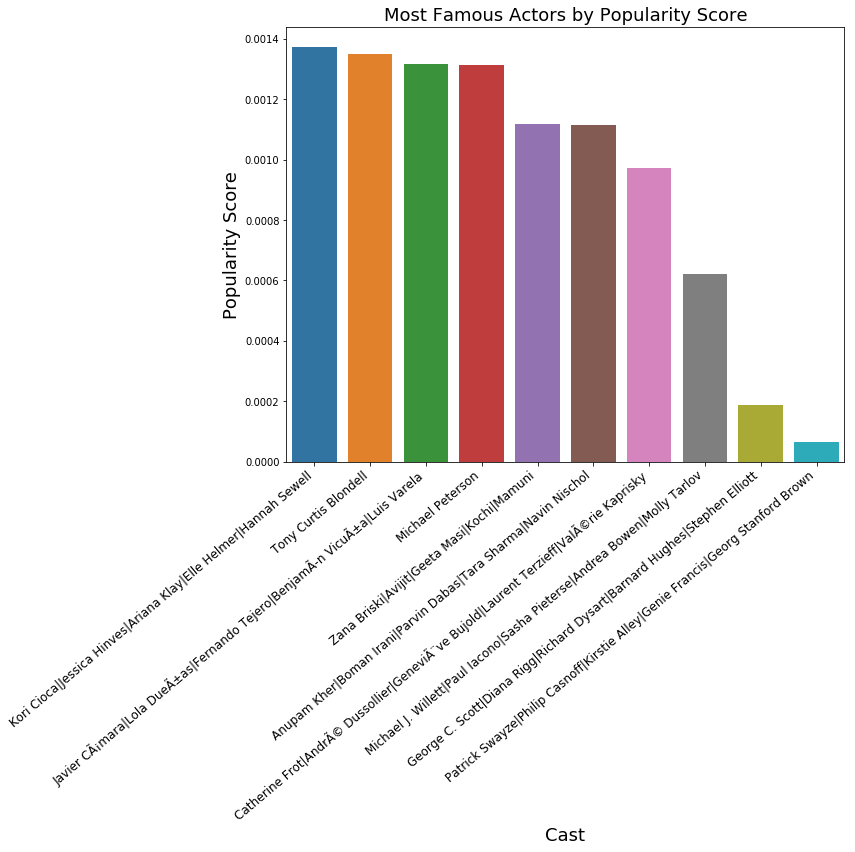

In [22]:
moviesSortedbyPopularity = df.sort_values(by = 'popularity', ascending = True).head(10)
moviesCastSortedbyPopularity=moviesSortedbyPopularity.groupby('cast').sum().sort_values(by = 'popularity' , ascending = False )[0:10]
#get cast column back in dataframe 
moviesCastSortedbyPopularity['cast'] = moviesCastSortedbyPopularity.index.get_level_values(0)
plt.figure(figsize=(10,8))
ab=sns.barplot(x = 'cast', y ='popularity',data =moviesCastSortedbyPopularity );
#Rotate x tick labels
ab.set_xticklabels(ab.get_xticklabels(),rotation = 40, ha ='right', fontsize = 12 );

plt.xlabel('Cast', fontsize = 18);
plt.ylabel('Popularity Score', fontsize = 18);
plt.title('Most Famous Actors by Popularity Score', fontsize = 18);

# Question 8 what is run time distribution  of all movies?

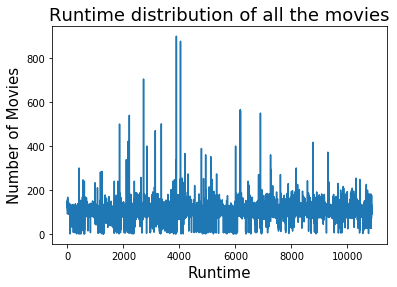

In [23]:

plt.plot(df['runtime'])
plt.xlabel('Runtime', fontsize = 15)
plt.ylabel('Number of Movies', fontsize=15)
plt.title('Runtime distribution of all the movies', fontsize=18);

<a id='conclusions'></a>
## Conclusions

>  1-year 2014 year has the highest release of movies (700) followed by year 2013 (659) and year 2015 (629).

>2-the higher number of release in september and october month. 

>3-Drame, Comedy, Thriller and Action are four most-made genres.

>4-'Avatar' movie earn the highest profit in all, making over 2.5B in profit in 
this dataset.And the most in loss movie in this dataset is The Warrior's Way.

>5-the Movie Which Has Highest budget is The Warrior's Way and the Movie Which Has Lowest budget is Fear Clinic 

>6-Top High Revenue movie is jurassic world 

>7-Maximum profited year 2015 and Minimum profited year 1966

>8-mounth of max number of movies is sep


> Limitations 

>1- It's not 100 percent guaranteed solution that this formula is gonna work, But it shows us that we have high probability of making high profits if we had similar characteristics as such. If we release a movie with these characteristics, it gives people high expectations from this movie. This was just one example of an influantial factor that would lead to different results, there are many that have to be taken care of.

>2-Above observations may not be accurate, as statistical methods are not used to infer information and only basic visualizations are used. Further analysis is required to produce accurate information. some rows are deleted from data set due to non existent values , this may effect the analysis and USD is considered as common currency for columns reveneu_adj and budget_adj. This may effect the profit trend of movies over the years.


In [24]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0